In [7]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import glob, time 

from astropy.io import fits as fits
from astropy.table import Table, vstack
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable

import healpy as hp
import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.targets import desi_mask, bgs_mask, mws_mask 
from desitarget.geomask import get_imaging_maskbits 

import fitsio
from fitsio import FITS,FITSHDR

nside = 32
orig_density_per_deg = 2500 #random

#files
# all_randoms = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/random0/rancomb_brightwdup_Alltiles.fits'
main_survey_randoms1 = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits'
main_survey_randoms2 = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-2-0.fits'

In [8]:
#apply the bgs masks to the randoms to make the filling factor more accurate

def bgs_mask_randoms(random):    
    
    

    # Apply custom imaging mask around bright stars etc.   
    bitnamelist = ["BRIGHT", "CLUSTER"] 
    bits = get_imaging_maskbits(bitnamelist) 
    retain_random = np.ones(len(random['MASKBITS']), dtype=bool) #got rid of .data as didnt work below 

    for bit, ttype in zip(bits, bitnamelist): 
        # Keep random if bit not set for bits corresponding to BRIGHT and CLUSTER. 
        retain_random &= ((random['MASKBITS'] & 2**bit) == 0)  

        #print to show amount of randoms cut 
        print(ttype, bit, np.mean(retain_random))

    #other cuts
    NOBS_mask = ((random['NOBS_G'] > 0) | (random['NOBS_R'] > 0) | (random['NOBS_Z'] > 0))
    
    #final mask with all masks incorporated 
    retain_random = retain_random & NOBS_mask
 
    #again print to show updated cuts 
    print('NOBS', np.mean(retain_random))

    return random[retain_random]

In [11]:
#open randoms
f = fits.open(main_survey_randoms1)
random1=f[1].data

In [12]:
#apply bgs mask to randoms and printed statement shows cuts 
random1=bgs_mask_randoms(random1)

BRIGHT 1 0.9905997485514495
CLUSTER 13 0.9904709859266433
NOBS 0.9771151783418405


In [13]:
#create mollview map of randoms now they've undergone these cuts 

theta = np.pi / 2. - np.radians(random1['DEC'].data)
phi = np.radians(random1['RA'].data)

#indices of pixels with non-zero density, unorganised list
all_pixel_indices1 = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

del f
del random1

In [14]:
#second set of randoms 
g = fits.open(main_survey_randoms2)
random2=g[1].data

In [15]:
#apply bgs mask to randoms and printed statement shows cuts 
random2=bgs_mask_randoms(random2)

BRIGHT 1 0.9905926121438843
CLUSTER 13 0.9904621002917477
NOBS 0.9771372306417164


In [16]:
#create mollview map of randoms now they've undergone these cuts 
theta = np.pi / 2. - np.radians(random2['DEC'].data)
phi = np.radians(random2['RA'].data)

#indices of pixels with non-zero density, unorganised list
all_pixel_indices2 = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

del g
del random2

In [17]:
all_pixel_indices_tot = np.concatenate((all_pixel_indices1,all_pixel_indices2))

In [18]:
#number of pixels on sphere and pixel area
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside,degrees=True)

print(npix)

12288


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


12288

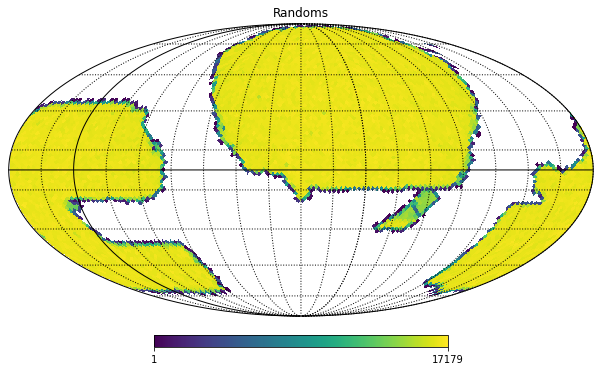

In [24]:
#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices_tot, return_counts=True) 

#no. targets per pixel, initially 0 
target_pixel_density = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
target_pixel_density[filled_pixel_index] = filled_targets_per_pixel 
target_pixel_density[target_pixel_density == 0] = np.NaN 

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='Randoms')
hp.graticule(dpar=5, dmer=5) 
    
#correct pixel area based on actual vs expected density 
exp_density_per_pixel = pixel_area * 2*orig_density_per_deg
filling_factor = target_pixel_density/exp_density_per_pixel
corr_pixel_area = pixel_area * filling_factor 

len(filling_factor)

In [25]:
#this ones wrong bc dont have target id when made the two lists as deleted but it will work 
SV3_area = len(all_pixel_indices_tot)/orig_density_per_deg*2
print('{} deg^2'.format(SV3_area))

SV3_area_2 = pixel_area*len(filled_pixel_index) 
print('{} deg^2'.format(SV3_area_2))


SV3_area_3 = np.sum(corr_pixel_area)
print('{} deg^2'.format(SV3_area_3))


80885.2416 deg^2
21788.06302968189 deg^2
nan deg^2


Text(0.5, 0, 'Random filling factor')

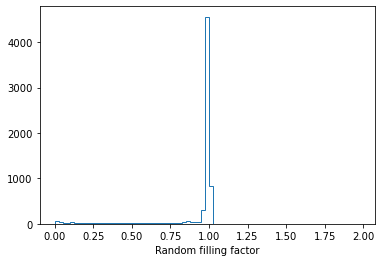

In [21]:
#histogram of filling factor: why does it have this shape?
_ = plt.hist(filling_factor, bins=np.arange(0.0, 2.0, 0.025), histtype='step')
plt.xlabel('Random filling factor')

In [22]:
#main survey data: files are in healpixels so this just creates a big file of them all 
#and makes cuts so it's bgs only 

#working with main survey randoms here i.e not sv3
to_grab=glob.glob('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/main/bright/mtl-bright-hp-*.ecsv') 

# very good practice to apply sorted, otherwise the file ordering will be random 	and non-repeatable.  
to_grab = sorted(to_grab) 

hp_stack = []

#do timer as takes a while
start = time.time() 

#total number of pixels, not quite sure where this has come from as npix is less than this above 
npix_todo = 200000

mmask = 'BGS_TARGET'
ttype = 'BGS_BRIGHT'

#loop through pixels
for i, x in enumerate(to_grab):
    x = pd.read_csv(x, comment='#', delimiter='\s+', usecols=['RA', 'DEC', 'TARGETID', 'BGS_TARGET', 'MWS_TARGET'])

    #mask for bgs objects
    is_bgs = (x[mmask] & bgs_mask[ttype]) != 0
    idx = np.arange(len(x))[is_bgs]
    x = x.iloc[idx] 
    hp_stack.append(x)

    #more timing stuff
    if (i % 100) == 0:
        runtime = (time.time() - start)

        print('Runtime of {:.6f} seconds after {:d} pixels'.format(runtime, i))

    if i > npix_todo:
        break
        
# Create a big table from the list of tables.  
data_stack = pd.concat(hp_stack, ignore_index=True)

#unique targets only and put it in right table format
mask,idx = np.unique(data_stack['TARGETID'],return_index=True)
data_stack = data_stack.iloc[idx]
data_stack = Table.from_pandas(data_stack)

#more timing stuff
runtime = (time.time() - start)
print('\n\nTotal runtime of {:.6f} seconds after {:d} pixels'.format(runtime, npix_todo))

data_stack

Runtime of 0.082690 seconds after 0 pixels
Runtime of 7.799107 seconds after 100 pixels
Runtime of 18.236250 seconds after 200 pixels
Runtime of 25.490952 seconds after 300 pixels
Runtime of 37.713565 seconds after 400 pixels
Runtime of 46.758010 seconds after 500 pixels
Runtime of 57.203905 seconds after 600 pixels
Runtime of 66.052762 seconds after 700 pixels
Runtime of 80.074695 seconds after 800 pixels
Runtime of 90.053075 seconds after 900 pixels
Runtime of 97.439617 seconds after 1000 pixels
Runtime of 108.536929 seconds after 1100 pixels
Runtime of 121.206518 seconds after 1200 pixels
Runtime of 133.947059 seconds after 1300 pixels
Runtime of 144.839179 seconds after 1400 pixels
Runtime of 155.253938 seconds after 1500 pixels
Runtime of 164.231589 seconds after 1600 pixels
Runtime of 174.557837 seconds after 1700 pixels
Runtime of 183.091106 seconds after 1800 pixels
Runtime of 189.544168 seconds after 1900 pixels
Runtime of 198.925552 seconds after 2000 pixels
Runtime of 208.49

RA,DEC,TARGETID,BGS_TARGET,MWS_TARGET
float64,float64,int64,int64,int64
59.60086559409994,-68.12683131313392,39626498281308189,131074,0
60.00983139575825,-68.16966639837612,39626498281308607,131074,0
60.01124019929327,-68.16379040745758,39626498281308610,131074,0
60.067316634746724,-68.1403940503445,39626498281308675,131074,0
60.27687723658043,-68.1477166136955,39626498285502547,131074,0
60.351730827700045,-68.1384524183673,39626498285502613,131074,0
60.35480903565853,-68.15736062454609,39626498285502619,131074,0
60.41502834204189,-68.14758441322456,39626498285502711,131074,0
60.57191230896668,-68.15293728255374,39626498285502939,131074,0


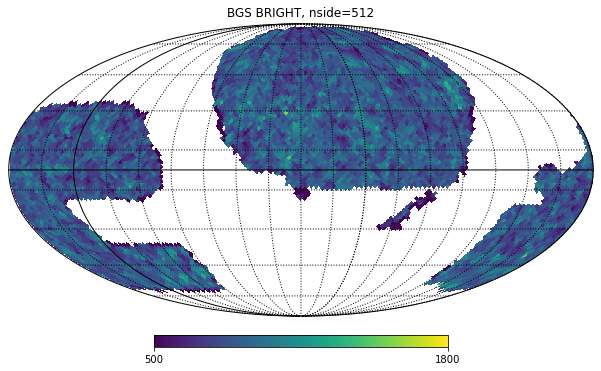

In [26]:
#set coordinates
theta = np.pi / 2. - np.radians(data_stack['DEC'].data)
phi = np.radians(data_stack['RA'].data)

#indices of pixels with non-zero density, unorganised list.
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#get rid of low density healpixels
targets_per_pixel[(filling_factor < 0.5)] = np.NaN 

target_pixel_density = targets_per_pixel/corr_pixel_area

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='BGS BRIGHT, nside=512',min=500,max=1800)
hp.graticule(dpar=5, dmer=5) 
    

Text(0.5, 1.0, 'Two randoms')

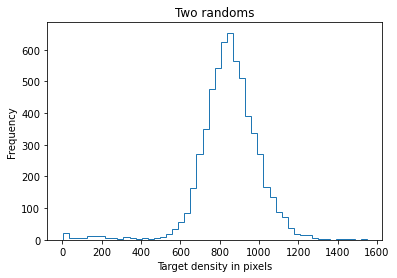

In [27]:
two_rand_pixel_density = target_pixel_density

#histogram of density: why does it have this shape?
_ = plt.hist(two_rand_pixel_density, bins=50,histtype='step')
plt.xlabel('Random filling factor')
plt.xlabel('Target density in pixels')
plt.ylabel('Frequency')
plt.title('Two randoms')

In [ ]:
#So above was for two randoms.  Below lets do it for one random:

In [30]:
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside,degrees=True)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


12288

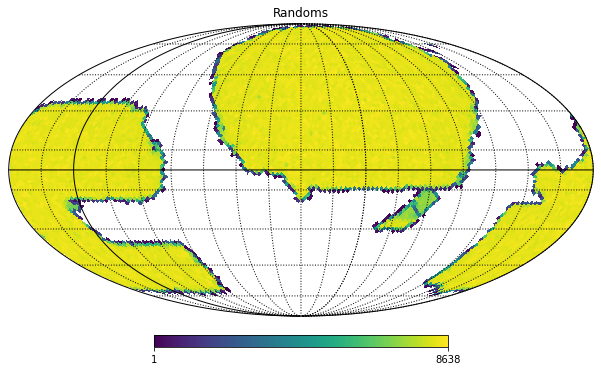

In [31]:
#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices1, return_counts=True) 

#no. targets per pixel, initially 0 
target_pixel_density = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
target_pixel_density[filled_pixel_index] = filled_targets_per_pixel 
target_pixel_density[target_pixel_density == 0] = np.NaN 

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='Randoms')
hp.graticule(dpar=5, dmer=5) 
    
#correct pixel area based on actual vs expected density 
exp_density_per_pixel = pixel_area *orig_density_per_deg
filling_factor = target_pixel_density/exp_density_per_pixel
corr_pixel_area = pixel_area * filling_factor 

len(corr_pixel_area)

Text(0.5, 0, 'Random filling factor')

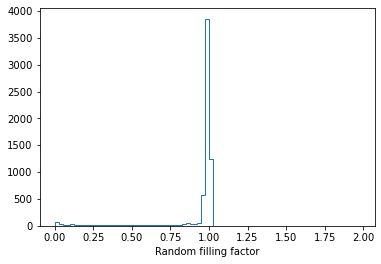

In [32]:
#histogram of filling factor: why does it have this shape?
_ = plt.hist(filling_factor, bins=np.arange(0.0, 2.0, 0.025), histtype='step')
plt.xlabel('Random filling factor')

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


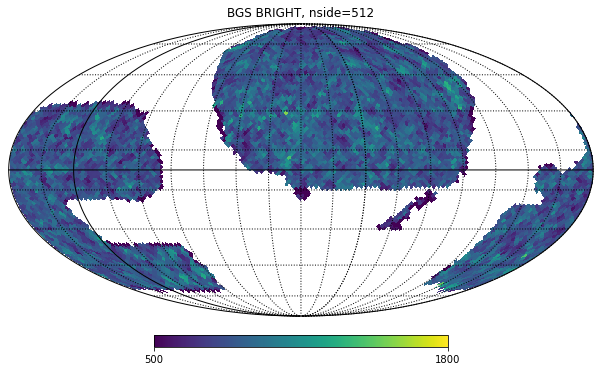

In [33]:
#set coordinates
theta = np.pi / 2. - np.radians(data_stack['DEC'].data)
phi = np.radians(data_stack['RA'].data)

#indices of pixels with non-zero density, unorganised list.
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#get rid of low density healpixels
targets_per_pixel[(filling_factor < 0.5)] = np.NaN 

target_pixel_density = targets_per_pixel/corr_pixel_area

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='BGS BRIGHT, nside=512',min=500,max=1800)
hp.graticule(dpar=5, dmer=5) 
    

Text(0.5, 1.0, 'One random')

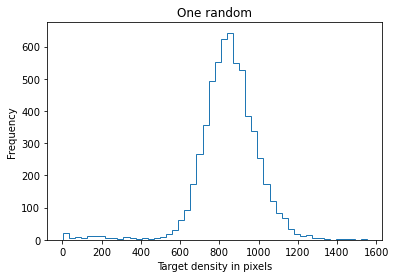

In [34]:
one_rand_pixel_density = target_pixel_density

#histogram of density: why does it have this shape?
_ = plt.hist(one_rand_pixel_density, bins=50,histtype='step')
plt.xlabel('Target density in pixels')
plt.ylabel('Frequency')
plt.title('One random')

Text(0.5, 1.0, 'Difference in density: 2 randoms - 1 random')

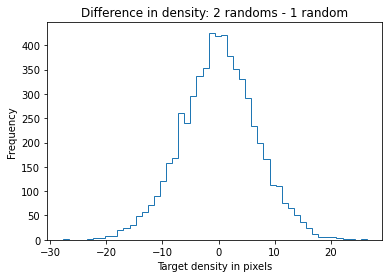

In [35]:
_ = plt.hist(two_rand_pixel_density - one_rand_pixel_density, bins=50,histtype='step')
plt.xlabel('Random filling factor')

plt.xlabel('Target density in pixels')
plt.ylabel('Frequency')
plt.title('Difference in density: 2 randoms - 1 random')